### Multi Class classification using  n-layer Neural Network on the Apparel dataset


In [1]:
import numpy as np 
import pandas as pd 
from scipy.special import expit
import matplotlib.pyplot as plt
import pickle

In [2]:
df=pd.read_csv("Apparel/apparel-trainval.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Visualisation of just single training Example

In [3]:
img=np.array(df.loc[:, df.columns != 'label'].iloc[1]).reshape(28,28) 


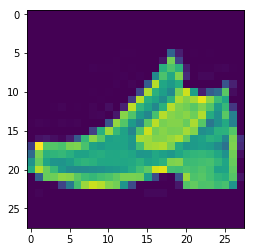

In [4]:
plt.imshow(img)

#### Spliting the Data ->
1. Training  data (80% )


2. Test data(20%)

In [5]:
split1 = int(0.8 * df.shape[0])
split2= int(.2*df.shape[0])
training_data = df[:split1]
testing_data = df[split1:]  

In [6]:
print(training_data.shape)
print(testing_data.shape)

(48000, 785)
(12000, 785)


In [7]:
Y_train=np.matrix(training_data['label'])
print(Y_train.shape)
training_data=training_data.drop('label',axis=1)
X_train=np.matrix(training_data)
X_train=X_train.T

(1, 48000)


#### For test data

In [8]:
Y_test=np.matrix(testing_data['label'])
print(Y_test.shape)
testing_data=testing_data.drop('label',axis=1)
X_test=np.matrix(testing_data)
X_test=X_test.T

(1, 12000)


##### Encoded the Y ,so that we can do the Multiclass classification

In [9]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False,categories='auto')
y_onehot = encoder.fit_transform(Y_train.T)
y_onehot=y_onehot.T



In [10]:
shape_X = X_train.shape
shape_Y = y_onehot.shape
m =  X_train.shape[1] # training set size

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (784, 48000)
The shape of Y is: (10, 48000)
I have m = 48000 training examples!


###  Algorithm

1.     Define the neural network structure ( # of input units,  # of hidden units, etc). 
2.    Initialize the model's parameters
3.    Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)
        
        
 4.   Combine all functions
 5.    Prediction

In [11]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {} # empty dictionary to hold return weights and bias term
    L = len(layer_dims)            

    for l in range(1, L):
        
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
        
    return parameters

#### Activation Forward

In this notebook, we will use two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. 


- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$.


- **tanh** : $\tanh(Z) = {\frac{e^z-e^{-z}}{e^z+e^{-z}}}$




In [12]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

def tanh(Z):
    A= np.divide(np.exp(Z)-np.exp(-Z),np.exp(Z)+np.exp(-Z))
    cache =Z
    return A,cache

**Sigmoid derivative**
$\sigma'(x) = s(1-s)$

**tanh derivative**
$\tanh'(x)=1-\tanh^2(x)$

In [13]:
def relu_backward(dA, cache):

    Z = cache
    dZ = np.array(dA, copy=True) 
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    
    Z = cache
    s = np.power(1+np.exp(-Z),-1)
    
#     print(dA.shape)
#     print(s.shape)
    dZ = np.multiply(dA ,np.multiply(s,(1-s)))
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def tanh_backward(dA, cache):
    Z=cache
    s= np.divide(np.exp(Z)-np.exp(-Z),np.exp(Z)+np.exp(-Z))
    dZ=np.multiply(dA ,1-np.power(s,2))
    
    return dZ

In [65]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [66]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    
    elif activation == "relu":
        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [67]:
def L_model_forward(X, parameters):
    
    caches = []
    
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    
    for l in range(1, L):
        A_prev = A 
        
        W=parameters["W"+str(l)]
        b=parameters["b"+str(l)]
        A, cache = linear_activation_forward(A_prev, W, b, "relu")
        caches.append(cache)
        
    
    W=parameters["W"+str(L)]
    b=parameters["b"+str(L)]
    AL, cache = linear_activation_forward(A, W, b, "sigmoid")
    caches.append(cache)
    
    
    assert(AL.shape == (10,X.shape[1]))

    return AL, caches

 Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{(i)}\right) + (1-y^{(i)})\log\left(1- a^{(i)}\right)) \tag{7}$$


In [68]:
def compute_cost(AL, Y):
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (-1/m)*np.sum(np.multiply(Y,np.log(AL))+np.multiply(1-Y,np.log(1-AL)))
    
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [69]:
def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ,A_prev.T)
    
    
    db = (1/m)*np.sum(dZ,axis=1).reshape(b.shape)
    
    dA_prev =np.dot(W.T,dZ)
    
    
    return dA_prev, dW, db

In [70]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ=relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    
    return dA_prev, dW, db

In [71]:
def L_model_backward(AL, Y, caches):
    
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    
    
    current_cache = caches[-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache,"sigmoid")
    
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)],current_cache,"relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        

    return grads

In [72]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network

    
    for l in range(L):
        parameters["W" + str(l+1)] =parameters["W" + str(l+1)]- learning_rate*grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] =parameters["b" + str(l+1)]- learning_rate*grads["db"+str(l+1)]
    
    return parameters

In [73]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 2000, print_cost=False):
    

    np.random.seed(1)
    costs = [] # empty list to hold the cost 
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):    
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    
    plt.ylabel('cost')
    plt.xlabel('epochs (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [74]:
def predict(X, y, parameters):
    
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    predictioned = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    predictioned=np.argmax(probas,axis=0)
    assert (predictioned.shape == y.shape)

    
    print("Accuracy: "  + str(np.sum((predictioned== y)/m*100)))
        
    return predictioned


#### 1 Hidden Layer Model


Cost after iteration 0: 7.767262
Cost after iteration 100: 5.978021
Cost after iteration 200: 5.269828
Cost after iteration 300: 4.772753
Cost after iteration 400: 4.417287
Cost after iteration 500: 4.158025
Cost after iteration 600: 3.966576
Cost after iteration 700: 3.828992
Cost after iteration 800: 3.715769
Cost after iteration 900: 3.627922
Cost after iteration 1000: 3.558955
Cost after iteration 1100: 3.504244
Cost after iteration 1200: 3.460442
Cost after iteration 1300: 3.425086
Cost after iteration 1400: 3.396307
Cost after iteration 1500: 3.372556
Cost after iteration 1600: 3.353402
Cost after iteration 1700: 3.337372
Cost after iteration 1800: 3.324086
Cost after iteration 1900: 3.313000


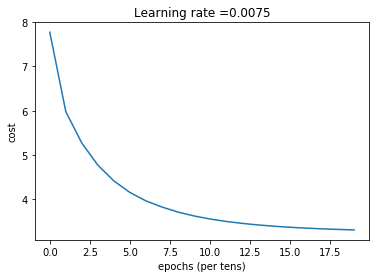

In [36]:
layers_dims = [784, 20,10] 
alpha=0.0075
parameters = L_layer_model(X_train, y_onehot,layers_dims,alpha, num_iterations = 2000, print_cost = True)

#### Accuracy on Training data

In [39]:
predict(X_train, Y_train, parameters)

Accuracy: 10.068750000000001


matrix([[6, 6, 6, ..., 6, 6, 6]])

#### Accuracy on Test data

In [40]:
predict(X_test,Y_test,parameters)

Accuracy: 9.725000000000001


matrix([[6, 6, 6, ..., 6, 6, 6]])

### 2 Hidden Layer Model

Cost after iteration 0: 6.955734
Cost after iteration 100: 1.959754
Cost after iteration 200: 1.270911
Cost after iteration 300: 1.106122
Cost after iteration 400: 0.990386
Cost after iteration 500: 0.934595
Cost after iteration 600: 0.911975
Cost after iteration 700: 0.840817
Cost after iteration 800: 0.844768
Cost after iteration 900: 0.829006
Cost after iteration 1000: 0.786784
Cost after iteration 1100: 0.766569
Cost after iteration 1200: 0.756861
Cost after iteration 1300: 0.777431
Cost after iteration 1400: 0.727968
Cost after iteration 1500: 0.714172
Cost after iteration 1600: 0.721917
Cost after iteration 1700: 0.699602
Cost after iteration 1800: 0.701247
Cost after iteration 1900: 0.696271


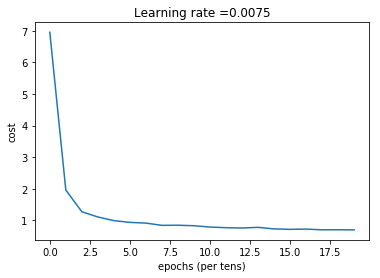

In [41]:
layers_dims = [784, 20, 20, 10] 
alpha=0.0075
parameters = L_layer_model(X_train, y_onehot,layers_dims,alpha, num_iterations = 2000, print_cost = True)

In [ ]:
# with open('weights2.pickle', 'wb') as handle:
#     pickle.dump(parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
with open('weights2.pickle', 'rb') as handle:
    Unserialised_parameters1 = pickle.load(handle)

#### Accuracy on Train Data

In [30]:
pred_train = predict(X_train, Y_train, Unserialised_parameters1)

Accuracy: 85.9125


#### Accuracy on Test data

In [31]:
pred_test=predict(X_test,Y_test,Unserialised_parameters1)

Accuracy: 84.96666666666665


### 3 Hidden Layer Model

Cost after iteration 0: 6.931779
Cost after iteration 100: 3.451656
Cost after iteration 200: 3.515390
Cost after iteration 300: 2.625005
Cost after iteration 400: 1.794404
Cost after iteration 500: 1.505451
Cost after iteration 600: 1.445971
Cost after iteration 700: 1.318228
Cost after iteration 800: 1.242394
Cost after iteration 900: 1.132170
Cost after iteration 1000: 1.047615
Cost after iteration 1100: 1.034041
Cost after iteration 1200: 0.938162
Cost after iteration 1300: 0.887044
Cost after iteration 1400: 0.839799
Cost after iteration 1500: 0.799414
Cost after iteration 1600: 0.779112
Cost after iteration 1700: 0.768358
Cost after iteration 1800: 0.748881
Cost after iteration 1900: 0.722442


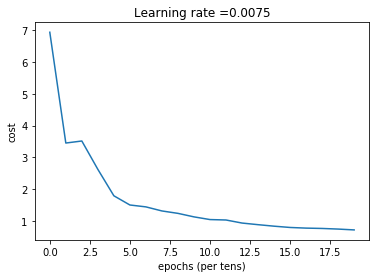

In [67]:
layers_dims = [784, 30, 20 ,20, 10]
parameters = L_layer_model(X_train, y_onehot,layers_dims, num_iterations = 2000, print_cost = True)

In [68]:
# with open('weights3.pickle', 'wb') as handle:
#     pickle.dump(parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [35]:
with open('weights3.pickle', 'rb') as handle:
    Unserialised_parameters2 = pickle.load(handle)

#### Accuracy on Train data

In [36]:
pred_train = predict(X_train, Y_train, Unserialised_parameters2)

Accuracy: 85.77291666666665


### Accuracy on test data

In [37]:
pred_valid=predict(X_test,Y_test,Unserialised_parameters2)

Accuracy: 84.74166666666666


###  Varying the no. of nodes in hidden layer

Cost after iteration 0: 6.951851
Cost after iteration 100: 1.722734
Cost after iteration 200: 1.209377
Cost after iteration 300: 1.018093
Cost after iteration 400: 0.905856
Cost after iteration 500: 0.857402
Cost after iteration 600: 0.818961
Cost after iteration 700: 0.764299
Cost after iteration 800: 0.776119
Cost after iteration 900: 0.753445
Cost after iteration 1000: 0.724068
Cost after iteration 1100: 0.683431
Cost after iteration 1200: 0.684181
Cost after iteration 1300: 0.690008
Cost after iteration 1400: 0.672478
Cost after iteration 1500: 0.655430
Cost after iteration 1600: 0.667247
Cost after iteration 1700: 0.611427
Cost after iteration 1800: 0.637498
Cost after iteration 1900: 0.620933


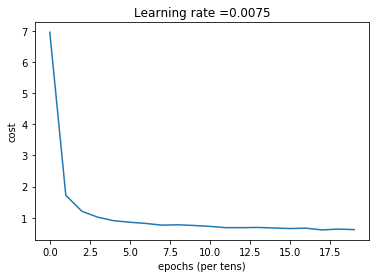

In [71]:
layers_dims = [784, 30, 30, 10] #  2-hidden layer model
alpha=.0075
parameters = L_layer_model(X_train, y_onehot,layers_dims,alpha, num_iterations = 2000, print_cost = True)

In [72]:
# with open('finalWeights.pickle', 'wb') as handle:
#     pickle.dump(parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [75]:
with open('finalWeights.pickle', 'rb') as handle:
    Unserialised_parameters3 = pickle.load(handle)

#### Accuracy on Train Data

In [76]:
pred_train = predict(X_train, Y_train, Unserialised_parameters3)

Accuracy: 87.90833333333333


#### Accuracy on Test set

In [77]:
pred_valid=predict(X_test,Y_test,Unserialised_parameters3)

Accuracy: 86.33333333333333


###  Run on Final Test File

In [107]:
forFinalTest=pd.read_csv("apparel-test.csv")
forFinalTest.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,9,8,0,...,103,87,56,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,0,63,53,31,0,0,0
3,0,0,0,0,0,0,0,0,0,161,...,137,126,140,0,133,224,222,56,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
def predictForTest(X,parameters):
    
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    predictioned = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    predictioned=np.argmax(probas,axis=0)
    
    return predictioned

In [109]:
X_FinalTest=np.matrix(forFinalTest)
X_FinalTest=X_FinalTest.T
print(X_FinalTest.shape)

(784, 9674)


In [110]:
with open('finalWeights.pickle', 'rb') as handle:
    parameters_forPrediction = pickle.load(handle)

In [111]:
finalPrediction=predictForTest(X_FinalTest,parameters_forPrediction)
finalPrediction.shape

(1, 9674)

In [112]:
finalPredictionList =finalPrediction.tolist()

In [115]:
with open('2018201017_prediction.csv', 'w') as file:
    for i in range(0,finalPrediction.shape[1]):
                   file.write('\n'.join(str(finalPrediction[0,i])))
                   file.write('\n')
                   
    

### No of Hidden layers vs Prediction loss 

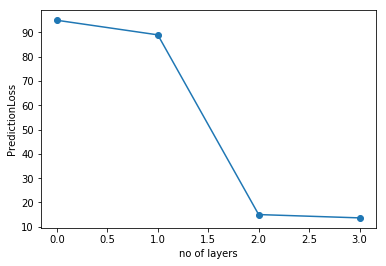

In [2]:
noofLayers=[0,1,2,3]
PredictionLoss=[95,89,15.0333,13.6666]

plt.scatter(noofLayers,PredictionLoss) 
plt.plot(noofLayers,PredictionLoss)
plt.ylabel('PredictionLoss')
plt.xlabel('no of layers')

plt.show()
